In [2]:
!pip install mediapipe

   ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
   ------ --------------------------------- 8.7/51.0 MB 44.9 MB/s eta 0:00:01
   ----------------- ---------------------- 22.5/51.0 MB 59.4 MB/s eta 0:00:01
   -------------------------- ------------- 34.3/51.0 MB 57.4 MB/s eta 0:00:01
   --------------------------------- ------ 43.0/51.0 MB 53.6 MB/s eta 0:00:01
   ---------------------------------------  49.8/51.0 MB 49.5 MB/s eta 0:00:01
   ---------------------------------------- 51.0/51.0 MB 46.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ------- -------------------------------- 8.1/46.2 MB 38.7 MB/s eta 0:00:01
   ------------- -------------------------- 15.7/46.2 MB 39.6 MB/s eta 0:00:01
   -------------------- ------------------- 23.9/46.2 MB 38.7 MB/s eta 0:00:01
   ----------------------------- ---------- 33.6/46.2 MB 41.8 MB/s eta 0:00:01
   ----------------------------------- ---- 41.2/46.2 MB 40.9 MB/s eta 0

In [1]:
import mediapipe as mp

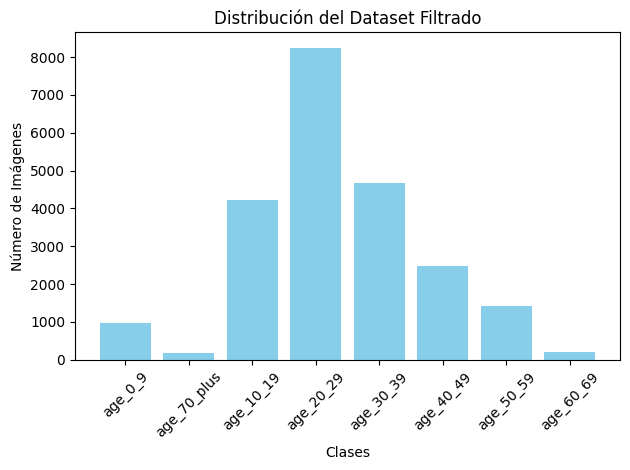

Número total de imágenes descartadas: 15754


In [2]:
import mediapipe as mp
import cv2
from pathlib import Path
import shutil
from collections import Counter
import matplotlib.pyplot as plt

# ===== PARÁMETROS =====
DATASET_ORIGINAL = Path("dataset_rangos_10_split")
DATASET_FILTRADO = Path("dataset_10_split_filtered")
IMG_SIZE = (224, 224)
CLASES_70_PLUS = ["age_70_79", "age_80_89", "age_90_99", "age_100_109", "age_110_119"]

# Inicializar MediaPipe
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# ===== FUNCIONES =====
def detectar_rostro(filepath):
    """Detectar si hay un rostro en la imagen."""
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        image = cv2.imread(str(filepath))
        if image is None:
            return False  # Imagen no válida
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)
        return results.detections is not None

def procesar_dataset():
    """Procesar el dataset original para filtrar imágenes y agrupar clases mayores a 70 años."""
    descartadas = 0  # Contador de imágenes descartadas
    distribucion = Counter()  # Para contar imágenes procesadas por clase

    # Crear la carpeta de salida
    if DATASET_FILTRADO.exists():
        shutil.rmtree(DATASET_FILTRADO)
    DATASET_FILTRADO.mkdir()

    # Procesar las carpetas de train, valid y test
    for split in ["train", "valid", "test"]:
        split_original = DATASET_ORIGINAL / split
        split_filtrado = DATASET_FILTRADO / split
        split_filtrado.mkdir()

        for clase in split_original.iterdir():
            # Definir la clase de salida
            if clase.name in CLASES_70_PLUS:
                clase_destino = split_filtrado / "age_70_plus"
            else:
                clase_destino = split_filtrado / clase.name
            
            clase_destino.mkdir(exist_ok=True)
            distribucion[clase_destino.name] += 0

            # Procesar imágenes de la clase
            for img_path in clase.iterdir():
                if detectar_rostro(img_path):
                    # Copiar la imagen si pasa el filtro
                    shutil.copy(img_path, clase_destino / img_path.name)
                    distribucion[clase_destino.name] += 1
                else:
                    descartadas += 1

    return distribucion, descartadas

# ===== PROCESAR =====
distribucion, descartadas = procesar_dataset()

# ===== VISUALIZAR DISTRIBUCIÓN =====
plt.bar(distribucion.keys(), distribucion.values(), color="skyblue")
plt.title("Distribución del Dataset Filtrado")
plt.xlabel("Clases")
plt.ylabel("Número de Imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Número total de imágenes descartadas: {descartadas}")
